In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf

print(tf.__version__)

2.9.2


In [ ]:
# !pip install tensorflow

In [ ]:
# !pip install sklearn

In [ ]:
# !pip install missingno

# 1. 데이터 로드 및 확인

In [ ]:
# import libraries
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import os
import numpy as np
import pandas as pd
import math, random
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style('whitegrid')
from scipy import stats
import missingno as msno

# display all columns
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_row', None)

In [ ]:
# load data
train_data = pd.read_csv('/content/drive/MyDrive/최종프로젝트/physionet2012_train.csv')
valid_data = pd.read_csv('/content/drive/MyDrive/최종프로젝트/physionet2012_valid.csv')
test_data = pd.read_csv('/content/drive/MyDrive/최종프로젝트/physionet2012_test.csv')

train_data.drop(['Unnamed: 0'], axis=1, inplace=True)
valid_data.drop(['Unnamed: 0'], axis=1, inplace=True)
test_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242613 entries, 0 to 242612
Data columns (total 45 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   pid          242613 non-null  int64  
 1   rec_time     242613 non-null  object 
 2   age          242613 non-null  float64
 3   Gender       242613 non-null  float64
 4   ICUType      242613 non-null  float64
 5   ALP          2480 non-null    float64
 6   ALT          2549 non-null    float64
 7   AST          2552 non-null    float64
 8   Albumin      1892 non-null    float64
 9   BUN          11220 non-null   float64
 10  Bilirubin    2551 non-null    float64
 11  Cholesterol  273 non-null     float64
 12  Creatinine   11274 non-null   float64
 13  FiO2         26127 non-null   float64
 14  GCS          49959 non-null   float64
 15  Glucose      10513 non-null   float64
 16  HCO3         10972 non-null   float64
 17  HCT          14762 non-null   float64
 18  HR           242613 non-

In [ ]:
# labeling
# train_data
train_data['label'] = 0
train_data.loc[(2 <= train_data['survival'])&(train_data['survival'] <= train_data['LOS']), 'label'] = 1
train_data.loc[train_data['survival'] > train_data['LOS'], 'label'] = 0
train_data.loc[train_data['survival'] == -1, 'label'] = 0

# valid_data
valid_data['label'] = 0
valid_data.loc[(2 <= valid_data['survival'])&(valid_data['survival'] <= valid_data['LOS']), 'label'] = 1
valid_data.loc[valid_data['survival'] > valid_data['LOS'], 'label'] = 0
valid_data.loc[valid_data['survival'] == -1, 'label'] = 0

# test_data
test_data['label'] = 0
test_data.loc[(2 <= test_data['survival'])&(test_data['survival'] <= test_data['LOS']), 'label'] = 1
test_data.loc[test_data['survival'] > test_data['LOS'], 'label'] = 0
test_data.loc[test_data['survival'] == -1, 'label'] = 0

In [ ]:
train_df = train_data.copy()
valid_df = valid_data.copy()
test_df = test_data.copy()

# 2. 결측값 처리

> **df.fillna(value=None, method=None, axis=None, inplace=False, limit=None, downcast=None)**
* value : 결측값을 대체할 값입니다. dict형태로도 가능합니다.
* method : 결측값을 변경할 방식입니다. bfill로 할경우 결측값을 바로 아래 값과 동일하게 변경합니다.
ffill로 할 경우 결측값을 바로 위 값과 동일하게 변경합니다.
* axis : {0 : index / 1 : columns} fillna 메서드를 적용할 레이블입니다.
* inplace : 원본을 변경할지 여부입니다. True일 경우 원본을 변경하게 됩니다.
* limit : 결측값을 변경할 횟수입니다. 위에서부터 limit로 지정된 갯수만큼만 변경합니다.
* downcast : 다운캐스트할지 여부입니다. downcast='infer'일 경우 float64를 int64로 변경합니다.

In [ ]:
# ffill
train_df.groupby(['pid']).fillna(method='ffill', inplace=True)
valid_df.groupby(['pid']).fillna(method='ffill', inplace=True)
test_df.groupby(['pid']).fillna(method='ffill', inplace=True)

Empty DataFrame
Columns: []
Index: []

In [ ]:
# median
train_df.fillna(train_df.median(), inplace=True)
valid_df.fillna(valid_df.median(), inplace=True)
test_df.fillna(test_df.median(), inplace=True)

# 3. 데이터 확인

In [ ]:
train_df.describe()

pid            age         Gender        ICUType  \
count  242613.000000  242613.000000  242613.000000  242613.000000   
mean   137598.163227      64.660979       0.567748       2.721355   
std      2895.568188      17.069362       0.497176       1.003291   
min    132540.000000      15.000000      -1.000000       1.000000   
25%    135127.000000      53.000000       0.000000       2.000000   
50%    137594.000000      67.000000       1.000000       3.000000   
75%    140031.000000      78.000000       1.000000       4.000000   
max    142671.000000      90.000000       1.000000       4.000000   

                 ALP            ALT            AST        Albumin  \
count  242613.000000  242613.000000  242613.000000  242613.000000   
mean       82.363727      46.252200      67.431234       2.900154   
std        14.178149     112.848326     159.476285       0.057804   
min        12.000000       1.000000       5.000000       1.000000   
25%        82.000000      43.000000      63.000000       2.900000   
50%        82.000000      43.000000      63.000000       2.900000   
75%        82.000000      43.000000      63.000000       2.900000   
max      2205.000000   11470.000000   18430.000000       5.000000   

                 BUN      Bilirubin    Cholesterol     Creatinine  \
count  242613.000000  242613.000000  242613.000000  242613.000000   
mean       20.333844       0.920969     154.004942       1.023582   
std         5.217707       0.636930       1.526859       0.375091   
min         0.000000       0.100000      28.000000       0.100000   
25%        20.000000       0.900000     154.000000       1.000000   
50%        20.000000       0.900000     154.000000       1.000000   
75%        20.000000       0.900000     154.000000       1.000000   
max       197.000000      47.700000     330.000000      22.100000   

                FiO2            GCS        Glucose           HCO3  \
count  242613.000000  242613.000000  242613.000000  242613.000000   
mean        0.504850      12.674613     127.632637      23.004035   
std         0.063831       1.906861      14.596424       1.008024   
min         0.210000       3.000000      10.000000       5.000000   
25%         0.500000      13.000000     127.000000      23.000000   
50%         0.500000      13.000000     127.000000      23.000000   
75%         0.500000      13.000000     127.000000      23.000000   
max         1.000000      15.000000    1143.000000      50.000000   

                 HCT             HR              K        Lactate  \
count  242613.000000  242613.000000  242613.000000  242613.000000   
mean       30.325126      87.772782       4.101816       2.121667   
std         1.249393      18.031186       0.155843       0.433795   
min        10.300000       0.000000       1.800000       0.300000   
25%        30.300000      76.000000       4.100000       2.100000   
50%        30.300000      86.000000       4.100000       2.100000   
75%        30.300000      98.000000       4.100000       2.100000   
max        61.800000     300.000000      22.900000      29.300000   

                  Mg             Na          PaCO2           PaO2  \
count  242613.000000  242613.000000  242613.000000  242613.000000   
mean        2.001087     139.001224      39.113103     124.225732   
std         0.086192       1.083102       2.547023      26.050993   
min         0.600000      98.000000       0.300000       0.000000   
25%         2.000000     139.000000      39.000000     122.000000   
50%         2.000000     139.000000      39.000000     122.000000   
75%         2.000000     139.000000      39.000000     122.000000   
max         7.700000     177.000000     100.000000     500.000000   

           Platelets             RR           SPO2             BT  Tropl  \
count  242613.000000  242613.000000  242613.000000  242613.000000    0.0   
mean      173.877780      19.154167      96.883451      36.977602    NaN   
std        23.496668       2.419724       2.256985       

In [ ]:
train_df.isnull().sum()

pid                 0
rec_time            0
age                 0
Gender              0
ICUType             0
ALP                 0
ALT                 0
AST                 0
Albumin             0
BUN                 0
Bilirubin           0
Cholesterol         0
Creatinine          0
FiO2                0
GCS                 0
Glucose             0
HCO3                0
HCT                 0
HR                  0
K                   0
Lactate             0
Mg                  0
Na                  0
PaCO2               0
PaO2                0
Platelets           0
RR                  0
SPO2                0
BT                  0
Tropl          242613
TroponinI           0
TropT          242613
TroponinT           0
Urine               0
WBC                 0
pH                  0
MechVent            0
survival            0
SBP                 0
DBP                 0
MBP                 0
male                0
female              0
surv_los            0
LOS                 0
label     

In [ ]:
train_df['label'].value_counts()

0    208513
1     34100
Name: label, dtype: int64

In [ ]:
train_df

pid         rec_time   age  Gender  ICUType   ALP   ALT   AST  \
0       142219          0:00:00  52.0     0.0      3.0  82.0  43.0  63.0   
1       142219          0:44:00  52.0     0.0      3.0  82.0  43.0  63.0   
2       142219          1:14:00  52.0     0.0      3.0  82.0  43.0  63.0   
3       142219          1:44:00  52.0     0.0      3.0  82.0  43.0  63.0   
4       142219          1:54:00  52.0     0.0      3.0  82.0  43.0  63.0   
...        ...              ...   ...     ...      ...   ...   ...   ...   
242608  138581  1 day, 20:36:00  53.0     1.0      4.0  82.0  43.0  63.0   
242609  138581  1 day, 21:36:00  53.0     1.0      4.0  82.0  43.0  63.0   
242610  138581  1 day, 22:36:00  53.0     1.0      4.0  82.0  43.0  63.0   
242611  138581  1 day, 23:36:00  53.0     1.0      4.0  82.0  43.0  63.0   
242612  138581  1 day, 23:49:00  53.0     1.0      4.0  82.0  43.0  63.0   

        Albumin   BUN  Bilirubin  Cholesterol  Creatinine  FiO2   GCS  \
0           2.9  20.0        0.9        154.0         1.0   0.5  13.0   
1           2.9  20.0        0.9        154.0         1.0   0.8  13.0   
2           2.9  20.0        0.9        154.0         1.0   0.5  13.0   
3           2.9  20.0        0.9        154.0         1.0   0.5  13.0   
4           2.9  20.0        0.9        154.0         1.0   0.5  13.0   
...         ...   ...        ...          ...         ...   ...   ...   
242608      2.9  20.0        0.9        154.0         1.0   0.4   8.0   
242609      2.9  20.0        0.9        154.0         1.0   0.5  13.0   
242610      2.9  20.0        0.9        154.0         1.0   0.5  13.0   
242611      2.9  20.0        0.9        154.0         1.0   0.5  13.0   
242612      2.9  17.0        0.9        154.0         0.8   0.5  13.0   

        Glucose  HCO3   HCT     HR    K  Lactate   Mg     Na  PaCO2   PaO2  \
0         127.0  23.0  30.3   86.0  4.1      2.1  2.0  139.0   39.0  122.0   
1         127.0  23.0  30.3  103.0  4.1      2.1  2.0  139.0   39.0  122.0   
2         127.0  23.0  30.3  100.0  4.1      2.1  2.0  139.0   39.0  122.0   
3         127.0  23.0  30.3  106.0  4.1      2.1  2.0  139.0   39.0  122.0   
4         127.0  23.0  30.3  105.0  4.1      2.1  2.0  139.0   39.0  122.0   
...         ...   ...   ...    ...  ...      ...  ...    ...    ...    ...   
242608    127.0  23.0  30.3   85.0  4.1      2.1  2.0  139.0   39.0  122.0   
242609    127.0  23.0  30.3   83.0  4.1      2.1  2.0  139.0   39.0  122.0   
242610    127.0  23.0  30.3   83.0  4.1      2.1  2.0  139.0   39.0  122.0   
242611    127.0  23.0  30.3   85.0  4.1      2.1  2.0  139.0   39.0  122.0   
242612    137.0  25.0  22.6   85.0  4.1      2.1  1.7  132.0   39.0  122.0   

        Platelets    RR   SPO2    BT  Tropl  TroponinI  TropT  TroponinT  \
0           173.0  19.0   97.0  37.1    NaN        2.9    NaN       0.22   
1           173.0  19.0   97.0  37.1    NaN        2.9    NaN       0.22   
2           173.0  19.0   97.0  37.1    NaN        2.9    NaN       0.22   
3           173.0  19.0   97.0  37.1    NaN        2.9    NaN       0.22   
4           173.0  19.0   97.0  37.1    NaN        2.9    NaN       0.22   
...           ...   ...    ...   ...    ...        ...    ...        ...   
242608      173.0  19.0  100.0  36.9    NaN        2.9    NaN       0.22   
242609      173.0  19.0  100.0  36.9    NaN        2.9    NaN       0.22   
242610      173.0  19.0  100.0  36.9    NaN        2.9    NaN       0.22   
242611      173.0  19.0  100.0  36.9    NaN        2.9    NaN       0.22   
242612      178.0  19.0  100.0  36.9    NaN        2.9    NaN       0.22   

        Urine   WBC    pH  MechVent  survival    SBP    DBP    MBP  male  \
0        70.0  11.5  7.38       1.0        -1  116.0   58.0   77.0     1   
1       500.0  11.5  7.38       1.0        -1  116.0   58.0   77.0     1   
2        70.0  11.5  7.38       1.0        -1    0.0    0.0  224.0     1   
3        70.0  11.5  7.38       1.0        -1    0.0    0.0  135.0 

In [ ]:
# 0:여성 1:남성
train_df['Gender'].unique()

array([ 0.,  1., -1.])

In [ ]:
train_df[train_df['Gender']==-1]['pid'].unique()
# 남자...?
# 141486 -> male:1 female:0
# 137392 -> male:1 female:0
# 135757 -> male:1 female:0

array([141486, 137392, 135757])

In [ ]:
# Gender -1값 1로 바꾸기
train_df.loc[train_df['Gender']==-1, 'Gender'] = 1 

In [ ]:
train_df['Gender'].unique()

array([0., 1.])

In [ ]:
# 1:관상동맥 2:심장 3:내과 4:외과
train_df['ICUType'].unique()

array([3., 4., 2., 1.])

In [ ]:
train_df.drop(columns=['rec_time', 'Tropl', 'TropT', 'male', 'female', 'survival', 'surv_los', 'LOS'], inplace=True)
valid_df.drop(columns=['rec_time', 'Tropl', 'TropT', 'male', 'female', 'survival', 'surv_los', 'LOS'], inplace=True)
test_df.drop(columns=['rec_time', 'Tropl', 'TropT', 'male', 'female', 'survival', 'surv_los', 'LOS'], inplace=True)

# 4. 데이터 시각화 

In [ ]:
train_df['label'].value_counts()/len(train_df.index)

0    0.859447
1    0.140553
Name: label, dtype: float64

In [ ]:
train_df[train_df['label']==1]['ICUType'].value_counts()/(train_df[train_df['label']==1]['ICUType'].value_counts()+train_df[train_df['label']==0]['ICUType'].value_counts())

1.0    0.167024
2.0    0.050572
3.0    0.186448
4.0    0.159788
Name: ICUType, dtype: float64

In [ ]:
# categorical data
def bar_chart(feature, ax=None):
    dead = train_df[train_df['label']==1][feature].value_counts() 
    survived = train_df[train_df['label']==0][feature].value_counts()
    df = pd.DataFrame([dead, survived])
    df.index = ['Dead', 'Survived']
    df.plot(kind='bar', stacked=True, ax=ax)

# numerical data(facets)
def draw_facetgrid(feature):
    facet = sns.FacetGrid(train_df, hue='label', aspect=5)
    facet.map(sns.kdeplot, feature, shade=True)
    facet.set(xlim=(0, train_df[feature].max()))
    facet.add_legend()
    plt.show()

In [ ]:
def count_plot(column, ax):
    sns.countplot(x=column, hue='label', data=train_df, ax=ax)

In [ ]:
corr_map = train_df[train_df.columns].corr()
color_map = plt.cm.PuBu

plt.figure(figsize=(25, 20))
sns.heatmap(corr_map, cmap = color_map, linewidths = 0.1, vmax =7, square = True, linecolor = "white", annot = True)

# 5. 데이터 패딩

In [ ]:
gr_train_df = train_df.groupby('pid')
gr_valid_df = valid_df.groupby('pid')
gr_test_df = test_df.groupby('pid')

In [ ]:
gr_train_df.size()
gr_valid_df.size()
gr_test_df.size()

pid
132551    94
132567    75
132570    46
132582    66
132584    94
          ..
142561    88
142573    62
142576    90
142595    45
142641    48
Length: 400, dtype: int64

In [ ]:
min(gr_train_df.size())

1

In [ ]:
len(train_df['pid'].unique())

3240

In [ ]:
len(valid_df['pid'].unique())

360

In [ ]:
len(test_df['pid'].unique())

400

In [ ]:
# train
pad_train_df = pd.DataFrame(columns = train_df.columns)
p = train_df['pid'].unique()
max_len = 70
for ep in p:
    if len(train_df[train_df['pid']==ep]) >= max_len:
        df = train_df[train_df['pid']==ep][:max_len]
        pad_train_df = pd.concat([pad_train_df, df])
    else:
        empty_df = pd.DataFrame(index=range(0,70), columns = train_df.columns) 
        empty_df[['pid']] = ep
        empty_df[['age']] = train_df[train_df['pid']==ep]['age'].values[0]
        empty_df[['Gender']] = train_df[train_df['pid']==ep]['Gender'].values[0]
        empty_df[['ICUType']] = train_df[train_df['pid']==ep]['ICUType'].values[0]
        empty_df[['label']] = train_df[train_df['pid']==ep]['label'].values[0]
        empty_df.iloc[-len(train_df[train_df['pid']==ep]):] = train_df[train_df['pid']==ep]
        empty_df.fillna(0, inplace=True)
        pad_train_df = pd.concat([pad_train_df, empty_df])

# valid
pad_valid_df = pd.DataFrame(columns = valid_df.columns)
p = valid_df['pid'].unique()
max_len = 70
for ep in p:
    if len(valid_df[valid_df['pid']==ep]) >= max_len:
        df = valid_df[valid_df['pid']==ep][:max_len]
        pad_valid_df = pd.concat([pad_valid_df, df])
    else:
        empty_df = pd.DataFrame(index=range(0,70), columns = valid_df.columns) 
        empty_df[['pid']] = ep
        empty_df[['age']] = valid_df[valid_df['pid']==ep]['age'].values[0]
        empty_df[['Gender']] = valid_df[valid_df['pid']==ep]['Gender'].values[0]
        empty_df[['ICUType']] = valid_df[valid_df['pid']==ep]['ICUType'].values[0]
        empty_df[['label']] = valid_df[valid_df['pid']==ep]['label'].values[0]
        empty_df.iloc[-len(valid_df[valid_df['pid']==ep]):] = valid_df[valid_df['pid']==ep]
        empty_df.fillna(0, inplace=True)
        pad_valid_df = pd.concat([pad_valid_df, empty_df])

# test
pad_test_df = pd.DataFrame(columns = test_df.columns)
p = test_df['pid'].unique()
max_len = 70
for ep in p:
    if len(test_df[test_df['pid']==ep]) >= max_len:
        df = test_df[test_df['pid']==ep][:max_len]
        pad_test_df = pd.concat([pad_test_df, df])
    else:
        empty_df = pd.DataFrame(index=range(0,70), columns = test_df.columns) 
        empty_df[['pid']] = ep
        empty_df[['age']] = test_df[test_df['pid']==ep]['age'].values[0]
        empty_df[['Gender']] = test_df[test_df['pid']==ep]['Gender'].values[0]
        empty_df[['ICUType']] = test_df[test_df['pid']==ep]['ICUType'].values[0]
        empty_df[['label']] = test_df[test_df['pid']==ep]['label'].values[0]
        empty_df.iloc[-len(test_df[test_df['pid']==ep]):] = test_df[test_df['pid']==ep]
        empty_df.fillna(0, inplace=True)
        pad_test_df = pd.concat([pad_test_df, empty_df])

In [ ]:
pad_train_df

pid   age  Gender  ICUType   ALP   ALT   AST  Albumin   BUN  \
0       142219  52.0     0.0      3.0  82.0  43.0  63.0      2.9  20.0   
1       142219  52.0     0.0      3.0  82.0  43.0  63.0      2.9  20.0   
2       142219  52.0     0.0      3.0  82.0  43.0  63.0      2.9  20.0   
3       142219  52.0     0.0      3.0  82.0  43.0  63.0      2.9  20.0   
4       142219  52.0     0.0      3.0  82.0  43.0  63.0      2.9  20.0   
...        ...   ...     ...      ...   ...   ...   ...      ...   ...   
242606  138581  53.0     1.0      4.0  82.0  43.0  63.0      2.9  20.0   
242607  138581  53.0     1.0      4.0  82.0  43.0  63.0      2.9  20.0   
242608  138581  53.0     1.0      4.0  82.0  43.0  63.0      2.9  20.0   
242609  138581  53.0     1.0      4.0  82.0  43.0  63.0      2.9  20.0   
242610  138581  53.0     1.0      4.0  82.0  43.0  63.0      2.9  20.0   

        Bilirubin  Cholesterol  Creatinine  FiO2   GCS  Glucose  HCO3   HCT  \
0             0.9        154.0         1.0   0.5  13.0    127.0  23.0  30.3   
1             0.9        154.0         1.0   0.8  13.0    127.0  23.0  30.3   
2             0.9        154.0         1.0   0.5  13.0    127.0  23.0  30.3   
3             0.9        154.0         1.0   0.5  13.0    127.0  23.0  30.3   
4             0.9        154.0         1.0   0.5  13.0    127.0  23.0  30.3   
...           ...          ...         ...   ...   ...      ...   ...   ...   
242606        0.9        154.0         1.0   0.5  13.0    127.0  23.0  30.3   
242607        0.9        154.0         1.0   0.5  13.0    127.0  23.0  30.3   
242608        0.9        154.0         1.0   0.4   8.0    127.0  23.0  30.3   
242609        0.9        154.0         1.0   0.5  13.0    127.0  23.0  30.3   
242610        0.9        154.0         1.0   0.5  13.0    127.0  23.0  30.3   

           HR    K  Lactate   Mg     Na  PaCO2   PaO2  Platelets    RR   SPO2  \
0        86.0  4.1      2.1  2.0  139.0   39.0  122.0      173.0  19.0   97.0   
1       103.0  4.1      2.1  2.0  139.0   39.0  122.0      173.0  19.0   97.0   
2       100.0  4.1      2.1  2.0  139.0   39.0  122.0      173.0  19.0   97.0   
3       106.0  4.1      2.1  2.0  139.0   39.0  122.0      173.0  19.0   97.0   
4       105.0  4.1      2.1  2.0  139.0   39.0  122.0      173.0  19.0   97.0   
...       ...  ...      ...  ...    ...    ...    ...        ...   ...    ...   
242606   93.0  4.1      2.1  2.0  139.0   39.0  122.0      173.0  19.0  100.0   
242607   94.0  4.1      2.1  2.0  139.0   39.0  122.0      173.0  19.0  100.0   
242608   85.0  4.1      2.1  2.0  139.0   39.0  122.0      173.0  19.0  100.0   
242609   83.0  4.1      2.1  2.0  139.0   39.0  122.0      173.0  19.0  100.0   
242610   83.0  4.1      2.1  2.0  139.0   39.0  122.0      173.0  19.0  100.0   

          BT  TroponinI  TroponinT  Urine   WBC    pH  MechVent    SBP    DBP  \
0       37.1        2.9       0.22   70.0  11.5  7.38       1.0  116.0   58.0   
1       37.1        2.9       0.22  500.0  11.5  7.38       1.0  116.0   58.0   
2       37.1        2.9       0.22   70.0  11.5  7.38       1.0    0.0    0.0   
3       37.1        2.9       0.22   70.0  11.5  7.38       1.0    0.0    0.0   
4       37.1        2.9       0.22  450.0  11.5  7.38       1.0  217.0  108.0   
...      ...        ...        ...    ...   ...   ...       ...    ...    ...   
242606  37.2        2.9       0.22   42.0  11.5  7.38       1.0  118.0   66.0   
242607  37.2        2.9       0.22  110.0  11.5  7.38       1.0  129.0   71.0   
242608  36.9        2.9       0.22   80.0  11.5  7.38       1.0  114.0   65.0   
242609  36.9        2.9       0.22   40.0  11.5  7.38       1.0  111.0   61.0   
242610  36.9        2.9       0.22   45.0  11.5  7.38       1.0  109.0   62.0   

          MBP label  
0        77.0     0  
1        77.0     0  
2       224.0     0  
3       135.0     0  
4       133.0     0  
...       ...   ...  
242606   85.0     1  
242607   93.0     1  
242608   84.0     1  
242609 

In [ ]:
pad_valid_df

pid   age  Gender  ICUType   ALP   ALT   AST  Albumin   BUN  \
0      140073  26.0     1.0      1.0   0.0   0.0   0.0      0.0   0.0   
1      140073  26.0     1.0      1.0   0.0   0.0   0.0      0.0   0.0   
2      140073  26.0     1.0      1.0   0.0   0.0   0.0      0.0   0.0   
3      140073  26.0     1.0      1.0   0.0   0.0   0.0      0.0   0.0   
4      140073  26.0     1.0      1.0   0.0   0.0   0.0      0.0   0.0   
...       ...   ...     ...      ...   ...   ...   ...      ...   ...   
27082  137443  71.0     1.0      1.0  87.0  42.5  64.0      2.9  20.0   
27083  137443  71.0     1.0      1.0  87.0  42.5  64.0      2.9  20.0   
27084  137443  71.0     1.0      1.0  87.0  42.5  64.0      2.9  20.0   
27085  137443  71.0     1.0      1.0  87.0  42.5  64.0      2.9  20.0   
27086  137443  71.0     1.0      1.0  87.0  42.5  64.0      2.9  11.0   

       Bilirubin  Cholesterol  Creatinine  FiO2   GCS  Glucose  HCO3   HCT  \
0            0.0          0.0         0.0   0.0   0.0      0.0   0.0   0.0   
1            0.0          0.0         0.0   0.0   0.0      0.0   0.0   0.0   
2            0.0          0.0         0.0   0.0   0.0      0.0   0.0   0.0   
3            0.0          0.0         0.0   0.0   0.0      0.0   0.0   0.0   
4            0.0          0.0         0.0   0.0   0.0      0.0   0.0   0.0   
...          ...          ...         ...   ...   ...      ...   ...   ...   
27082        1.0        137.5         1.0   0.5  13.0    127.0  23.0  30.1   
27083        1.0        137.5         1.0   0.5  15.0    127.0  23.0  30.1   
27084        1.0        137.5         1.0   0.5  13.0    127.0  23.0  30.1   
27085        1.0        137.5         1.0   0.5  13.0    127.0  23.0  30.1   
27086        1.0        137.5         0.8   0.5  13.0    102.0  27.0  28.4   

         HR    K  Lactate   Mg     Na  PaCO2   PaO2  Platelets    RR  SPO2  \
0       0.0  0.0      0.0  0.0    0.0    0.0    0.0        0.0   0.0   0.0   
1       0.0  0.0      0.0  0.0    0.0    0.0    0.0        0.0   0.0   0.0   
2       0.0  0.0      0.0  0.0    0.0    0.0    0.0        0.0   0.0   0.0   
3       0.0  0.0      0.0  0.0    0.0    0.0    0.0        0.0   0.0   0.0   
4       0.0  0.0      0.0  0.0    0.0    0.0    0.0        0.0   0.0   0.0   
...     ...  ...      ...  ...    ...    ...    ...        ...   ...   ...   
27082  84.0  4.1      2.0  2.0  139.0   39.0  121.0      167.0  19.0  97.0   
27083  83.0  4.1      2.0  2.0  139.0   39.0  121.0      167.0  15.0  97.0   
27084  87.0  4.1      2.0  2.0  139.0   39.0  121.0      167.0  19.0  97.0   
27085  79.0  4.1      2.0  2.0  139.0   39.0  121.0      167.0  21.0  97.0   
27086  79.0  3.9      2.0  1.9  140.0   39.0  121.0      116.0  21.0  97.0   

         BT  TroponinI  TroponinT  Urine   WBC    pH  MechVent    SBP   DBP  \
0       0.0        0.0       0.00    0.0   0.0  0.00       0.0    0.0   0.0   
1       0.0        0.0       0.00    0.0   0.0  0.00       0.0    0.0   0.0   
2       0.0        0.0       0.00    0.0   0.0  0.00       0.0    0.0   0.0   
3       0.0        0.0       0.00    0.0   0.0  0.00       0.0    0.0   0.0   
4       0.0        0.0       0.00    0.0   0.0  0.00       0.0    0.0   0.0   
...     ...        ...        ...    ...   ...   ...       ...    ...   ...   
27082  36.8        1.8       0.13   70.0  11.2  7.39       1.0  110.0  65.0   
27083  36.6        1.8       0.13  120.0  11.2  7.39       1.0  110.0  65.0   
27084  36.6        1.8       0.13   70.0  11.2  7.39       1.0  110.0  65.0   
27085  36.6        1.8       0.13  285.0  11.2  7.39       1.0  110.0  65.0   
27086  36.6        1.8       0.13   70.0   7.8  7.39       1.0  110.0  65.0   

        MBP label  
0       0.0     0  
1       0.0     0  
2       0.0     0  
3       0.0     0  
4       0.0     0  
...     ...   ...  
27082  82.0     0  
27083  82.0     0  
27084  82.0     0  
27085  82.0     0  
27086  82.0     0  

[25200 rows x 38 columns]

In [ ]:
pad_test_df

pid   age  Gender  ICUType   ALP   ALT   AST  Albumin   BUN  Bilirubin  \
0   135089  90.0     1.0      3.0   0.0   0.0   0.0      0.0   0.0        0.0   
1   135089  90.0     1.0      3.0   0.0   0.0   0.0      0.0   0.0        0.0   
2   135089  90.0     1.0      3.0   0.0   0.0   0.0      0.0   0.0        0.0   
3   135089  90.0     1.0      3.0   0.0   0.0   0.0      0.0   0.0        0.0   
4   135089  90.0     1.0      3.0   0.0   0.0   0.0      0.0   0.0        0.0   
..     ...   ...     ...      ...   ...   ...   ...      ...   ...        ...   
65  135219  78.0     0.0      4.0  85.0  45.0  72.0      2.9  20.0        0.8   
66  135219  78.0     0.0      4.0  85.0  45.0  72.0      2.9  20.0        0.8   
67  135219  78.0     0.0      4.0  85.0  45.0  72.0      2.9  20.0        0.8   
68  135219  78.0     0.0      4.0  85.0  45.0  72.0      2.9  20.0        0.8   
69  135219  78.0     0.0      4.0  85.0  45.0  72.0      2.9  11.0        0.8   

    Cholesterol  Creatinine  FiO2   GCS  Glucose  HCO3   HCT    HR    K  \
0           0.0         0.0   0.0   0.0      0.0   0.0   0.0   0.0  0.0   
1           0.0         0.0   0.0   0.0      0.0   0.0   0.0   0.0  0.0   
2           0.0         0.0   0.0   0.0      0.0   0.0   0.0   0.0  0.0   
3           0.0         0.0   0.0   0.0      0.0   0.0   0.0   0.0  0.0   
4           0.0         0.0   0.0   0.0      0.0   0.0   0.0   0.0  0.0   
..          ...         ...   ...   ...      ...   ...   ...   ...  ...   
65        143.5         1.0   0.5  14.0    127.0  23.0  30.4  59.0  4.0   
66        143.5         1.0   0.5  14.0    127.0  23.0  30.4  60.0  4.0   
67        143.5         1.0   0.5  14.0    127.0  23.0  30.4  66.0  4.0   
68        143.5         1.0   0.5  14.0    127.0  23.0  30.4  66.0  4.0   
69        143.5         1.2   0.5  14.0    101.0  23.0  26.6  66.0  4.0   

    Lactate   Mg     Na  PaCO2   PaO2  Platelets    RR  SPO2    BT  TroponinI  \
0       0.0  0.0    0.0    0.0    0.0        0.0   0.0   0.0   0.0        0.0   
1       0.0  0.0    0.0    0.0    0.0        0.0   0.0   0.0   0.0        0.0   
2       0.0  0.0    0.0    0.0    0.0        0.0   0.0   0.0   0.0        0.0   
3       0.0  0.0    0.0    0.0    0.0        0.0   0.0   0.0   0.0        0.0   
4       0.0  0.0    0.0    0.0    0.0        0.0   0.0   0.0   0.0        0.0   
..      ...  ...    ...    ...    ...        ...   ...   ...   ...        ...   
65      2.0  2.0  139.0   40.0  118.0      170.5  22.0  98.0  37.6        2.6   
66      2.0  2.0  139.0   40.0  118.0      170.5  22.0  98.0  37.6        2.6   
67      2.0  2.0  139.0   40.0  118.0      170.5  18.0  98.0  37.7        2.6   
68      2.0  2.0  139.0   40.0   90.0      170.5  18.0  98.0  37.7        2.6   
69      2.0  1.8  133.0   40.0  118.0      118.0  18.0  98.0  37.7        2.6   

    TroponinT  Urine   WBC    pH  MechVent    SBP   DBP   MBP label  
0        0.00    0.0   0.0  0.00       0.0    0.0   0.0   0.0     0  
1        0.00    0.0   0.0  0.00       0.0    0.0   0.0   0.0     0  
2        0.00    0.0   0.0  0.00       0.0    0.0   0.0   0.0     0  
3        0.00    0.0   0.0  0.00       0.0    0.0   0.0   0.0     0  
4        0.00    0.0   0.0  0.00       0.0    0.0   0.0   0.0     0  
..        ...    ...   ...   ...       ...    ...   ...   ...   ...  
65       0.18   35.0  11.0  7.38       1.0  134.0  51.0  79.0     0  
66       0.18   75.0  11.0  7.38       1.0  132.0  50.0  78.0     0  
67       0.18   45.0  11.0  7.38       1.0  139.0  54.0  84.0     0  
68       0.18   75.0  11.0  7.37       1.0  139.0  54.0  84.0     0  
69       0.18   75.0  10.6  7.38       1.0  139.0  54.0  84.0     0  

[28000 rows x 38 columns]

In [ ]:
pad_train_df.isnull().sum()

pid            0
age            0
Gender         0
ICUType        0
ALP            0
ALT            0
AST            0
Albumin        0
BUN            0
Bilirubin      0
Cholesterol    0
Creatinine     0
FiO2           0
GCS            0
Glucose        0
HCO3           0
HCT            0
HR             0
K              0
Lactate        0
Mg             0
Na             0
PaCO2          0
PaO2           0
Platelets      0
RR             0
SPO2           0
BT             0
TroponinI      0
TroponinT      0
Urine          0
WBC            0
pH             0
MechVent       0
SBP            0
DBP            0
MBP            0
label          0
dtype: int64

# 6. 범주형 데이터 원핫인코딩

In [ ]:
ohe_train_df = pd.get_dummies(pad_train_df, columns=['Gender', 'ICUType', 'MechVent'])
ohe_valid_df = pd.get_dummies(pad_valid_df, columns=['Gender', 'ICUType', 'MechVent'])
ohe_test_df = pd.get_dummies(pad_test_df, columns=['Gender', 'ICUType', 'MechVent'])

In [ ]:
ohe_train_df
# pid, Gender_0.0, Gender_1.0, label

pid   age   ALP   ALT   AST  Albumin   BUN  Bilirubin  Cholesterol  \
0       142219  52.0  82.0  43.0  63.0      2.9  20.0        0.9        154.0   
1       142219  52.0  82.0  43.0  63.0      2.9  20.0        0.9        154.0   
2       142219  52.0  82.0  43.0  63.0      2.9  20.0        0.9        154.0   
3       142219  52.0  82.0  43.0  63.0      2.9  20.0        0.9        154.0   
4       142219  52.0  82.0  43.0  63.0      2.9  20.0        0.9        154.0   
...        ...   ...   ...   ...   ...      ...   ...        ...          ...   
242606  138581  53.0  82.0  43.0  63.0      2.9  20.0        0.9        154.0   
242607  138581  53.0  82.0  43.0  63.0      2.9  20.0        0.9        154.0   
242608  138581  53.0  82.0  43.0  63.0      2.9  20.0        0.9        154.0   
242609  138581  53.0  82.0  43.0  63.0      2.9  20.0        0.9        154.0   
242610  138581  53.0  82.0  43.0  63.0      2.9  20.0        0.9        154.0   

        Creatinine  FiO2   GCS  Glucose  HCO3   HCT     HR    K  Lactate   Mg  \
0              1.0   0.5  13.0    127.0  23.0  30.3   86.0  4.1      2.1  2.0   
1              1.0   0.8  13.0    127.0  23.0  30.3  103.0  4.1      2.1  2.0   
2              1.0   0.5  13.0    127.0  23.0  30.3  100.0  4.1      2.1  2.0   
3              1.0   0.5  13.0    127.0  23.0  30.3  106.0  4.1      2.1  2.0   
4              1.0   0.5  13.0    127.0  23.0  30.3  105.0  4.1      2.1  2.0   
...            ...   ...   ...      ...   ...   ...    ...  ...      ...  ...   
242606         1.0   0.5  13.0    127.0  23.0  30.3   93.0  4.1      2.1  2.0   
242607         1.0   0.5  13.0    127.0  23.0  30.3   94.0  4.1      2.1  2.0   
242608         1.0   0.4   8.0    127.0  23.0  30.3   85.0  4.1      2.1  2.0   
242609         1.0   0.5  13.0    127.0  23.0  30.3   83.0  4.1      2.1  2.0   
242610         1.0   0.5  13.0    127.0  23.0  30.3   83.0  4.1      2.1  2.0   

           Na  PaCO2   PaO2  Platelets    RR   SPO2    BT  TroponinI  \
0       139.0   39.0  122.0      173.0  19.0   97.0  37.1        2.9   
1       139.0   39.0  122.0      173.0  19.0   97.0  37.1        2.9   
2       139.0   39.0  122.0      173.0  19.0   97.0  37.1        2.9   
3       139.0   39.0  122.0      173.0  19.0   97.0  37.1        2.9   
4       139.0   39.0  122.0      173.0  19.0   97.0  37.1        2.9   
...       ...    ...    ...        ...   ...    ...   ...        ...   
242606  139.0   39.0  122.0      173.0  19.0  100.0  37.2        2.9   
242607  139.0   39.0  122.0      173.0  19.0  100.0  37.2        2.9   
242608  139.0   39.0  122.0      173.0  19.0  100.0  36.9        2.9   
242609  139.0   39.0  122.0      173.0  19.0  100.0  36.9        2.9   
242610  139.0   39.0  122.0      173.0  19.0  100.0  36.9        2.9   

        TroponinT  Urine   WBC    pH    SBP    DBP    MBP label  Gender_0.0  \
0            0.22   70.0  11.5  7.38  116.0   58.0   77.0     0           1   
1            0.22  500.0  11.5  7.38  116.0   58.0   77.0     0           1   
2            0.22   70.0  11.5  7.38    0.0    0.0  224.0     0           1   
3            0.22   70.0  11.5  7.38    0.0    0.0  135.0     0           1   
4            0.22  450.0  11.5  7.38  217.0  108.0  133.0     0           1   
...           ...    ...   ...   ...    ...    ...    ...   ...         ...   
242606       0.22   42.0  11.5  7.38  118.0   66.0   85.0     1           0   
242607       0.22  110.0  11.5  7.38  129.0   71.0   93.0     1           0   
242608       0.22   80.0  11.5  7.38  114.0   65.0   84.0     1           0   
242609       0.22   40.0  11.5  7.38  111.0   61.0   80.0     1           0   
242610       0.22   45.0  11.5  7.38  109.0   62.0   80.0     1           0   

        Gender_1.0  ICUType_1.0  ICUType_2.0  ICUType_3.0  ICUType_4.0  \
0                0            0            0            1            0   
1                0            0            0            1            0   
2                0           

In [ ]:
ohe_train_df = ohe_train_df.astype('float')
ohe_valid_df = ohe_valid_df.astype('float')
ohe_test_df = ohe_test_df.astype('float')

In [ ]:
ordinary_train = ohe_train_df.copy()
ordinary_valid = ohe_valid_df.copy()
ordinary_test = ohe_test_df.copy()

# 7. 데이터 정규화

In [ ]:
ordinary_train.drop(columns=['pid', 'label'], axis=1, inplace=True)
ordinary_valid.drop(columns=['pid', 'label'], axis=1, inplace=True)
ordinary_test.drop(columns=['pid', 'label'], axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(ordinary_train)
scaled_train = scaler.transform(ordinary_train)
scaled_valid = scaler.transform(ordinary_valid)
scaled_test = scaler.transform(ordinary_test)
# scaled_train_df = pd.DataFrame(data=scaled_train, columns=ordinary_train.feature_names)

# 8. 모델링

In [ ]:
# 데이터 분리
train_X = scaled_train
train_y = ohe_train_df['label']

valid_X = scaled_valid
valid_y = ohe_valid_df['label']

test_X = scaled_test
test_y = ohe_test_df['label']

In [ ]:
print(train_X.shape, train_y.shape)

(226800, 41) (226800,)


In [ ]:
train_y

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
242606    1.0
242607    1.0
242608    1.0
242609    1.0
242610    1.0
Name: label, Length: 226800, dtype: float64

In [ ]:
# !pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)


In [ ]:
# imbalanced-learn 패키지
from imblearn.over_sampling import *
from imblearn.over_sampling import SMOTE

# 검증 데이터나 테스트 데이터가 아닌 학습데이터에서만 오버샘플링 사용할 것
# smote = SMOTE(random_state=0)
train_X_over, train_y_over = SMOTE(random_state=0).fit_resample(train_X, train_y)

In [ ]:
# reshape
print(train_X_over.shape, train_y_over.shape)
print(valid_X.shape, valid_y.shape)
print(test_X.shape, test_y.shape)

train_X_over = train_X_over.reshape(-1, max_len, train_X_over.shape[-1])
train_y_over = train_y_over[::70]
valid_X = valid_X.reshape(-1, max_len, valid_X.shape[-1])
valid_y = valid_y[::70]
test_X = test_X.reshape(-1, max_len, test_X.shape[-1])
test_y = test_y[::70]

print(train_X_over.shape, train_y_over.shape)
print(valid_X.shape, valid_y.shape)
print(test_X.shape, test_y.shape)

(393820, 41) (393820,)
(25200, 41) (25200,)
(28000, 41) (28000,)
(5626, 70, 41) (5626,)
(360, 70, 41) (360,)
(400, 70, 41) (400,)


In [ ]:
print(train_X_over.shape, train_y_over.shape)

(5626, 70, 41) (5626,)


In [ ]:
# train_X_over = train_X_over.reshape(train_X_over.shape[0], train_X_over.shape[1], 1)
# valid_X = valid_X.reshape(valid_X.shape[0], valid_X.shape[1], 1)
# test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

In [ ]:
# setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pprint import pprint
%matplotlib inline

In [ ]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential             
from keras.layers import Dense, Dropout, BatchNormalization, SimpleRNN, LSTM, Bidirectional, BatchNormalization, Activation, GRU
from keras.callbacks import EarlyStopping 
from keras.optimizers import RMSprop, Adam
from tensorflow.keras import models
from tensorflow.keras import layers

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical

In [ ]:
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU

In [ ]:
def auc_roc(y_true, y_pred):
    # can be any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)
    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]
    
    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)
    
    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
    return value

In [ ]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [ ]:
feature_dim = train_X_over.shape[-1]

In [ ]:
# RNN
rnn_model = Sequential()
rnn_model.add(SimpleRNN(128, input_shape = (max_len, feature_dim), return_sequences=True, activation='tanh'))
rnn_model.add(Dropout(0.5)) 
rnn_model.add(SimpleRNN(256, return_sequences=True, activation="tanh"))
rnn_model.add(Dropout(0.25)) 
rnn_model.add(SimpleRNN(128, return_sequences=True, activation="tanh"))
rnn_model.add(Dropout(0.25)) 
rnn_model.add(SimpleRNN(64, return_sequences=True, activation="tanh"))
rnn_model.add(Dropout(0.2)) 
rnn_model.add(SimpleRNN(32, return_sequences=True, activation="tanh"))
rnn_model.add(Dropout(0.2)) 
rnn_model.add(Flatten())
rnn_model.add(Dense(16, activation='tanh'))
rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',auc_roc])

In [ ]:
# LSTM
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(128, input_shape = (max_len, feature_dim), return_sequences=True, activation='tanh')))
lstm_model.add(Dropout(0.5)) 
lstm_model.add(Bidirectional(LSTM(256, return_sequences=True, activation="tanh")))
lstm_model.add(Dropout(0.25)) 
lstm_model.add(Bidirectional(LSTM(128, return_sequences=True, activation="tanh")))
lstm_model.add(Dropout(0.25)) 
lstm_model.add(Bidirectional(LSTM(64, return_sequences=True, activation="tanh")))
lstm_model.add(Dropout(0.2)) 
lstm_model.add(Bidirectional(LSTM(32, return_sequences=False, activation="tanh")))
lstm_model.add(Dropout(0.2)) 
lstm_model.add(Dense(16, activation='tanh'))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',auc_roc])

In [ ]:
# GRU
gru_model = Sequential()
gru_model.add(Bidirectional(GRU(128, input_shape = (max_len, feature_dim), return_sequences=True, activation='tanh')))
gru_model.add(Dropout(0.5)) 
gru_model.add(Bidirectional(GRU(256, return_sequences=True, activation="tanh")))
gru_model.add(Dropout(0.25)) 
gru_model.add(Bidirectional(GRU(128, return_sequences=True, activation="tanh")))
gru_model.add(Dropout(0.25)) 
gru_model.add(Bidirectional(GRU(64, return_sequences=True, activation="tanh"))) 
gru_model.add(Dropout(0.2)) 
gru_model.add(Bidirectional(GRU(32, return_sequences=False, activation="tanh"))) 
gru_model.add(Dropout(0.2)) 
gru_model.add(Dense(16, activation='tanh'))
gru_model.add(Dense(1, activation='sigmoid'))
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',auc_roc])

In [ ]:
import os

model_dir = '/content/drive/MyDrive/최종프로젝트/model3/'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

modelpath='/content/drive/MyDrive/최종프로젝트/model3/{epoch:02d}-{val_auc:.4f}.hdf5'

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

early_stop = EarlyStopping(monitor='val_auc_roc', patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_auc_roc', verbose=1, save_best_only=True)
# checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
# early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
rnn_model_history = rnn_model.fit(train_X_over, train_y_over, epochs=50, batch_size=10, validation_data=(valid_X, valid_y), verbose=1, callbacks=[checkpointer, early_stop])
rnn_history = rnn_model_history.history

Epoch 1/50


AttributeError: ignored

In [ ]:
lstm_model_history = lstm_model.fit(train_X_over, train_y_over, epochs=50, batch_size=10, validation_data=(valid_X, valid_y), verbose=1, callbacks=[checkpointer, early_stop])
lstm_history = lstm_model_history.history

Epoch 1/26
563/563 [==============================] - ETA: 0s - loss: 12.7675 - acc: 0.5130
Epoch 1: val_loss did not improve from 0.36969
563/563 [==============================] - 314s 546ms/step - loss: 12.7675 - acc: 0.5130 - val_loss: 0.6985 - val_acc: 0.4056
Epoch 2/26
563/563 [==============================] - ETA: 0s - loss: 33062.0625 - acc: 0.5684
Epoch 2: val_loss did not improve from 0.36969
563/563 [==============================] - 285s 506ms/step - loss: 33062.0625 - acc: 0.5684 - val_loss: 0.7216 - val_acc: 0.1667
Epoch 3/26
563/563 [==============================] - ETA: 0s - loss: 25.7166 - acc: 0.5857
Epoch 3: val_loss did not improve from 0.36969
563/563 [==============================] - 255s 453ms/step - loss: 25.7166 - acc: 0.5857 - val_loss: 0.7148 - val_acc: 0.1361
Epoch 4/26
563/563 [==============================] - ETA: 0s - loss: 141.8262 - acc: 0.5633
Epoch 4: val_loss did not improve from 0.36969
563/563 [==============================] - 249s 441ms/step 

In [ ]:
gru_model_history = gru_model.fit(train_X_over, train_y_over, epochs=50, batch_size=10, validation_data=(valid_X, valid_y), verbose=1, callbacks=[checkpointer, early_stop])
gru_history = gru_model_history.history 

Epoch 1/26
563/563 [==============================] - ETA: 0s - loss: 0.3752 - acc: 0.8198
Epoch 1: val_loss improved from inf to 0.42299, saving model to /content/drive/MyDrive/최종프로젝트/model2/01-0.4230.hdf5
563/563 [==============================] - 214s 364ms/step - loss: 0.3752 - acc: 0.8198 - val_loss: 0.4230 - val_acc: 0.8639
Epoch 2/26
563/563 [==============================] - ETA: 0s - loss: 0.2355 - acc: 0.9184
Epoch 2: val_loss did not improve from 0.42299
563/563 [==============================] - 203s 360ms/step - loss: 0.2355 - acc: 0.9184 - val_loss: 0.4380 - val_acc: 0.8556
Epoch 3/26
563/563 [==============================] - ETA: 0s - loss: 0.2368 - acc: 0.9165
Epoch 3: val_loss improved from 0.42299 to 0.39252, saving model to /content/drive/MyDrive/최종프로젝트/model2/03-0.3925.hdf5
563/563 [==============================] - 205s 363ms/step - loss: 0.2368 - acc: 0.9165 - val_loss: 0.3925 - val_acc: 0.8583
Epoch 4/26
563/563 [==============================] -

In [ ]:
# save model
# import pickle

# rnn_model.save(rnn_model)
# lstm_model.save(lstm_model)
# gru_model.save(gru_model)

## X

In [ ]:
# simple_rnn
simple_rnn_model = Sequential()
simple_rnn_model.add(SimpleRNN(128, input_shape = (41, 1)))
simple_rnn_model.add(layers.Dense(64, activation='relu'))
simple_rnn_model.add(layers.Dropout(0.5))
simple_rnn_model.add(layers.Dense(32, activation='relu'))
simple_rnn_model.add(layers.Dropout(0.25))
simple_rnn_model.add(layers.Dense(16, activation='relu'))
simple_rnn_model.add(layers.Dropout(0.25))
simple_rnn_model.add(layers.Dense(8, activation='relu'))
simple_rnn_model.add(layers.Dropout(0.2))
simple_rnn_model.add(layers.Dense(1, activation='sigmoid'))

simple_rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# lstm
lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape = (41, 1)))
lstm_model.add(layers.Dense(64, activation='relu'))
lstm_model.add(layers.Dropout(0.5))
lstm_model.add(layers.Dense(32, activation='relu'))
lstm_model.add(layers.Dropout(0.25))
lstm_model.add(layers.Dense(16, activation='relu'))
lstm_model.add(layers.Dropout(0.25))
lstm_model.add(layers.Dense(8, activation='relu'))
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# gru
gru_model = Sequential()
gru_model.add(GRU(128, input_shape = (41, 1)))
gru_model.add(layers.Dense(64, activation='relu'))
gru_model.add(layers.Dropout(0.5))
gru_model.add(layers.Dense(32, activation='relu'))
gru_model.add(layers.Dropout(0.25))
gru_model.add(layers.Dense(16, activation='relu'))
gru_model.add(layers.Dropout(0.25))
gru_model.add(layers.Dense(8, activation='relu'))
gru_model.add(layers.Dropout(0.2))
gru_model.add(layers.Dense(1, activation='sigmoid'))

gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
# early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
simple_rnn_model_history = simple_rnn_model.fit(train_X_over, train_y_over, epochs=26, batch_size=100, validation_data=(valid_X, valid_y), verbose=1, callbacks=[early_stop])
lstm_model_history = lstm_model.fit(train_X_over, train_y_over, epochs=26, batch_size=100, validation_data=(valid_X, valid_y), verbose=1, callbacks=[early_stop])
gru_model_history = gru_model.fit(train_X_over, train_y_over, epochs=26, batch_size=100, validation_data=(valid_X, valid_y), verbose=1, callbacks=[early_stop])

Epoch 1/26
3939/3939 [==============================] - 106s 27ms/step - loss: 0.6853 - acc: 0.5306 - val_loss: 0.6896 - val_acc: 0.8172
Epoch 2/26
3939/3939 [==============================] - 107s 27ms/step - loss: 0.6932 - acc: 0.4993 - val_loss: 0.7007 - val_acc: 0.1361
Epoch 3/26
3939/3939 [==============================] - 105s 27ms/step - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6870 - val_acc: 0.8639
Epoch 3: early stopping
Epoch 1/26
3939/3939 [==============================] - 350s 88ms/step - loss: 0.6785 - acc: 0.5572 - val_loss: 0.6381 - val_acc: 0.5719
Epoch 2/26
3939/3939 [==============================] - 348s 88ms/step - loss: 0.6412 - acc: 0.6389 - val_loss: 0.6659 - val_acc: 0.5669
Epoch 3/26
3939/3939 [==============================] - 352s 89ms/step - loss: 0.6325 - acc: 0.6496 - val_loss: 0.6657 - val_acc: 0.5371
Epoch 4/26
3939/3939 [==============================] - 361s 92ms/step - loss: 0.6242 - acc: 0.6593 - val_loss: 0.6577 - val_acc: 0.5389
Epoch 5/26
3939/3

# 9. 모델 평가

In [ ]:
from keras.models import load_model
rnn_model = load_model('/content/drive/MyDrive/최종프로젝트/model/rnn-20-0.3400.hdf5')
lstm_model = load_model('/content/drive/MyDrive/최종프로젝트/model/lstm-16-0.4009.hdf5')
gru_model = load_model('/content/drive/MyDrive/최종프로젝트/model/gru-23-0.3476.hdf5')

In [ ]:
# model score
rnn_model_score = rnn_model.evaluate(test_X, test_y)
lstm_model_score = lstm_model.evaluate(test_X, test_y)
gru_model_score = gru_model.evaluate(test_X, test_y)

13/13 [==============================] - 2s 125ms/step - loss: 0.3455 - acc: 0.8700


In [ ]:
# Accuracy
print('Test Accuracy_simple rnn: ', rnn_model_score[-1])
print('Test Accuracy_lstm: ', lstm_model_score[-1])
print('Test Accuracy_gru: ', gru_model_score[-1], '\n')

# Loss
print('Test Loss_simple rnn: ', rnn_model_score[0])
print('Test Loss_lstm: ', lstm_model_score[0])
print('Test Loss_gru: ', gru_model_score[0])

Test Accuracy_simple rnn:  0.8725000023841858
Test Accuracy_lstm:  0.8700000047683716
Test Accuracy_gru:  0.8700000047683716 

Test Loss_simple rnn:  0.3454706072807312
Test Loss_lstm:  0.391011506319046
Test Loss_gru:  0.3455038368701935


In [ ]:
# predict
rnn_pred = rnn_model.predict(test_X)
lstm_pred = lstm_model.predict(test_X)
gru_pred = gru_model.predict(test_X)

13/13 [==============================] - 2s 138ms/step


In [ ]:
# confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

# pred_1d = gru_pred.flatten() 
pred_binary = np.where(rnn_pred > 0.5, 1, 0)
print(classification_report(test_y, pred_binary))

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93       348
         1.0       1.00      0.02      0.04        52

    accuracy                           0.87       400
   macro avg       0.94      0.51      0.48       400
weighted avg       0.89      0.87      0.82       400



In [ ]:
# score 
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve, classification_report, accuracy_score, roc_auc_score, average_precision_score

print('Accuacy Score: ', accuracy_score(test_y, pred_binary))
print('ROC AUC Score: ', roc_auc_score(test_y, rnn_pred))

Accuacy Score:  0.8725
ROC AUC Score:  0.7413793103448275


In [ ]:
print(f"정확도 : {accuracy_score(test_y, pred_binary):.4f}")
print(f"정밀도 : {precision_score(test_y, pred_binary):.4f}")
print(f"재현율 : {recall_score(test_y, pred_binary):.4f}")
print(f"오차행렬 :\n {confusion_matrix(test_y, pred_binary)}")

정확도 : 0.8725
정밀도 : 1.0000
재현율 : 0.0192
오차행렬 :
 [[348   0]
 [ 51   1]]


In [ ]:
# RNN
rnn_fpr, rnn_tpr, rnn_thresholds = roc_curve(test_y, rnn_pred)
rnn_roc_auc = roc_auc_score(test_y, rnn_pred)

# LSTM
lstm_fpr, lstm_tpr, lstm_thresholds = roc_curve(test_y, lstm_pred)
lstm_roc_auc = roc_auc_score(test_y, lstm_pred)

# GRU
gru_fpr, gru_tpr, gru_thresholds = roc_curve(test_y, gru_pred)
gru_roc_auc = roc_auc_score(test_y, gru_pred)

In [ ]:
print('RNN_ROC AUC Score: ', roc_auc_score(test_y, rnn_pred))
print('LSTM_ROC AUC Score: ', roc_auc_score(test_y, lstm_pred))
print('GRU_ROC AUC Score: ', roc_auc_score(test_y, gru_pred))

RNN_ROC AUC Score:  0.7413793103448275
LSTM_ROC AUC Score:  0.4571175950486296
GRU_ROC AUC Score:  0.7624336870026525


In [ ]:
# !pip install yellowbrick

In [ ]:
from yellowbrick.classifier import ROCAUC

visualize = ROCAUC(simple_rnn_model, )

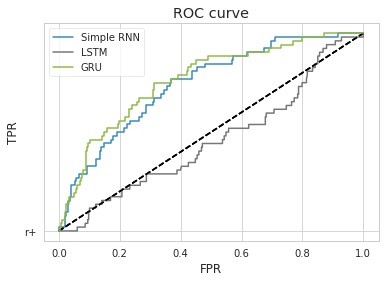

NameError: ignored

In [ ]:
# ROC 
from sklearn.metrics import roc_curve

fpr_rnn, tpr_rnn, thresholds_rnn = roc_curve(test_y, rnn_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(fpr_rnn, tpr_rnn, label='Simple RNN')

fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(test_y, lstm_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(fpr_lstm, tpr_lstm, label='LSTM')

fpr_gru, tpr_gru, thresholds_gru = roc_curve(test_y, gru_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(fpr_gru, tpr_gru, label='GRU')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC curve')
plt.show()

# recall-precision
precision =precision_score(test_y, pred_binary)
recall = recall_score(test_y, pred_binary)

plt.plot(precision, recall)
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend(loc='best')

# average-precision score
from sklearn.metrics import average_precision_score
avg_score = average_precision_score(test_y, rnn_pred)
avg_score